Successfully loaded data from ../data/sierraleone-bumbuna.csv
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-nu

C:\Users\User\AppData\Local\Temp\ipykernel_12520\3201497479.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_12520\3201497479.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('figures/bubble_chart_daytime.png')


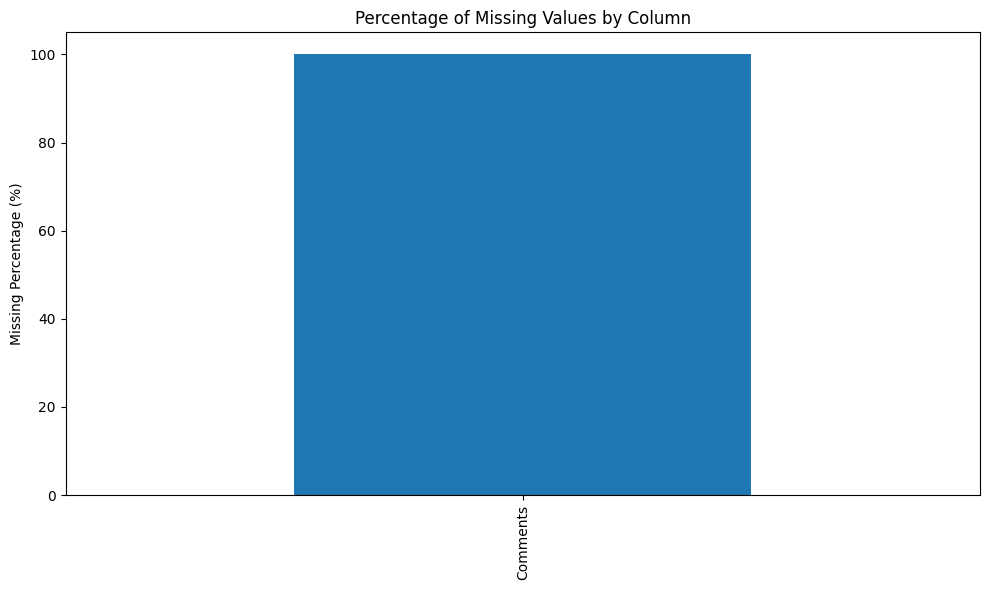

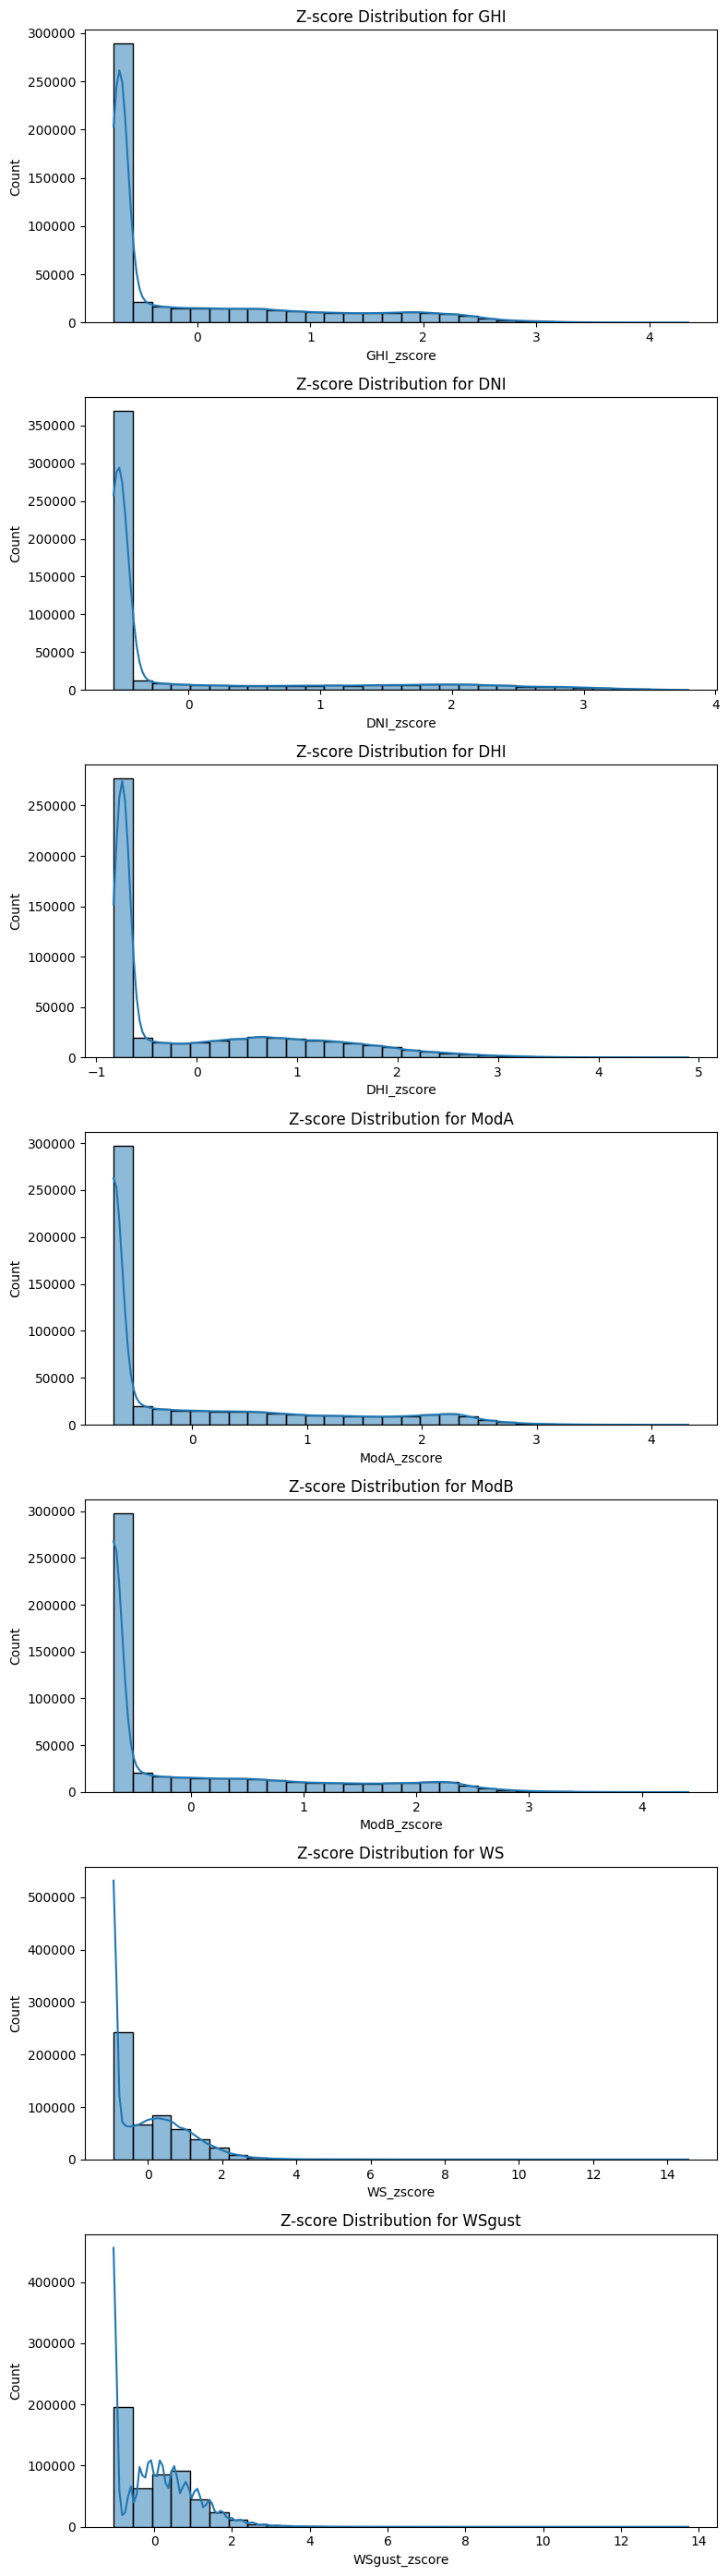

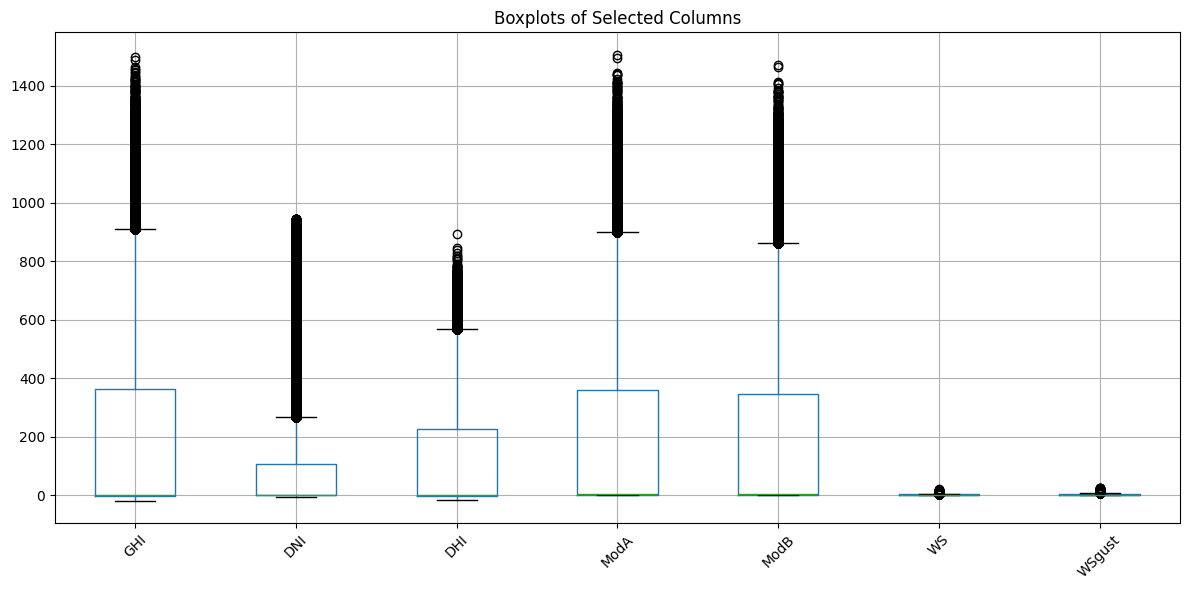

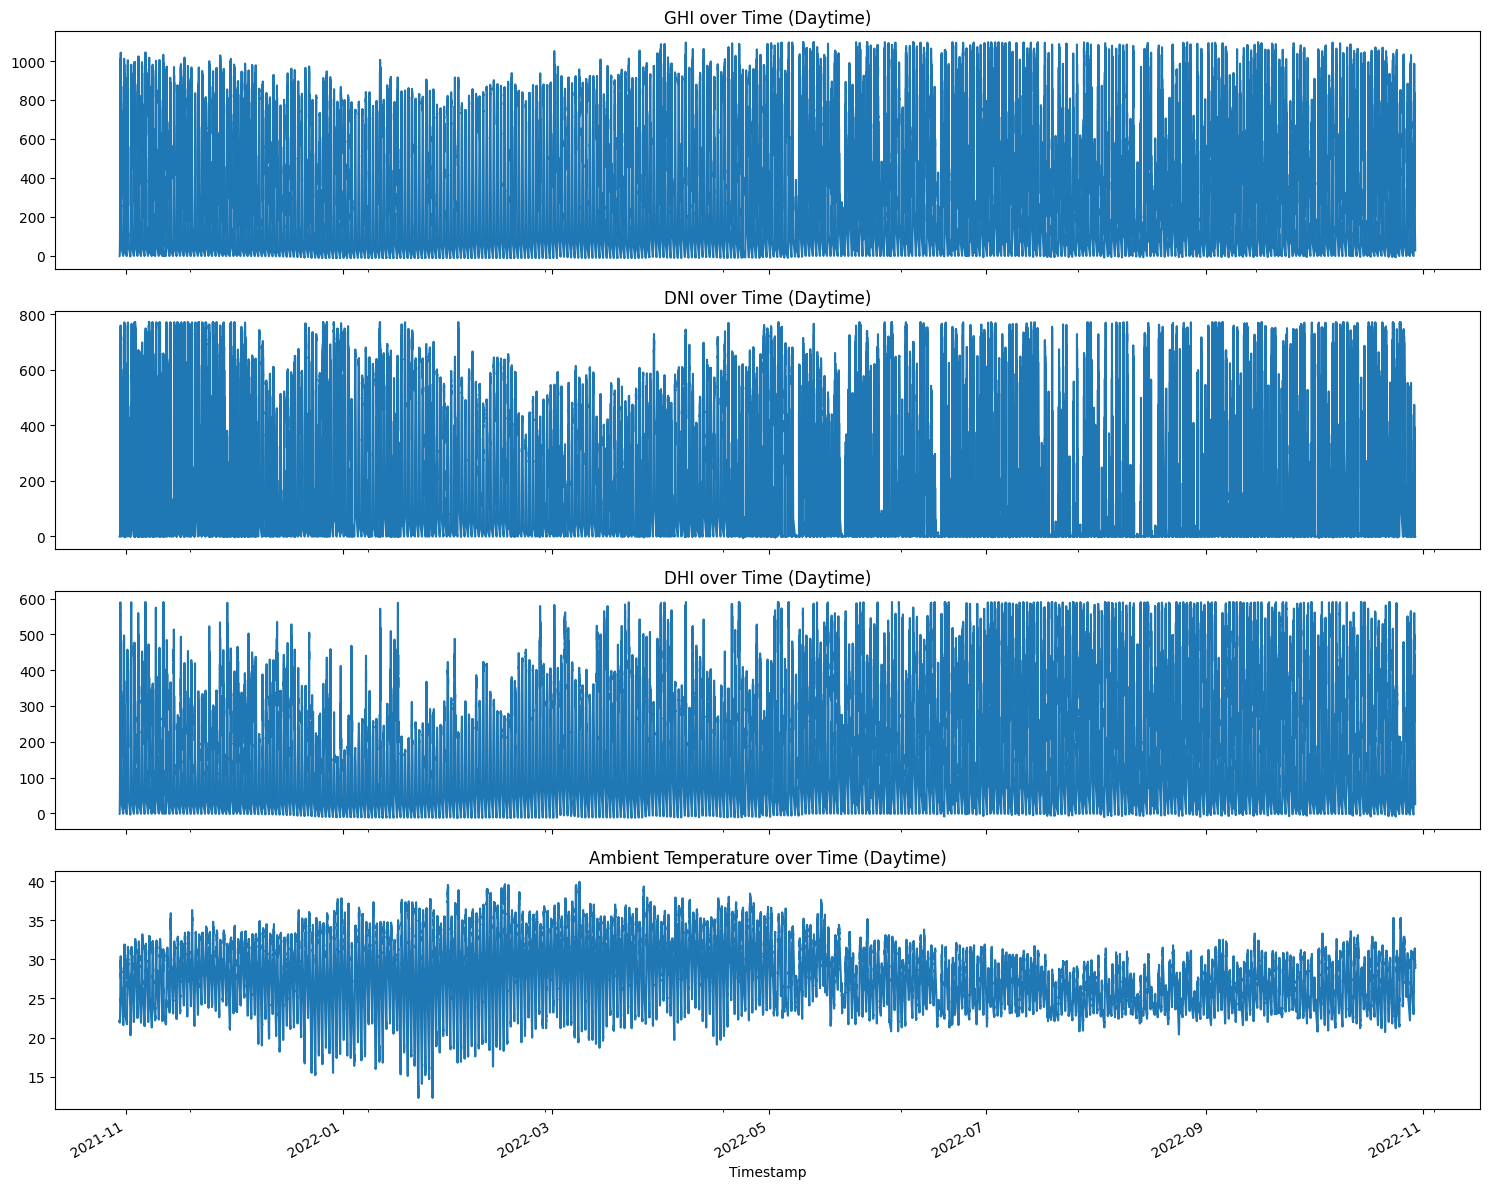

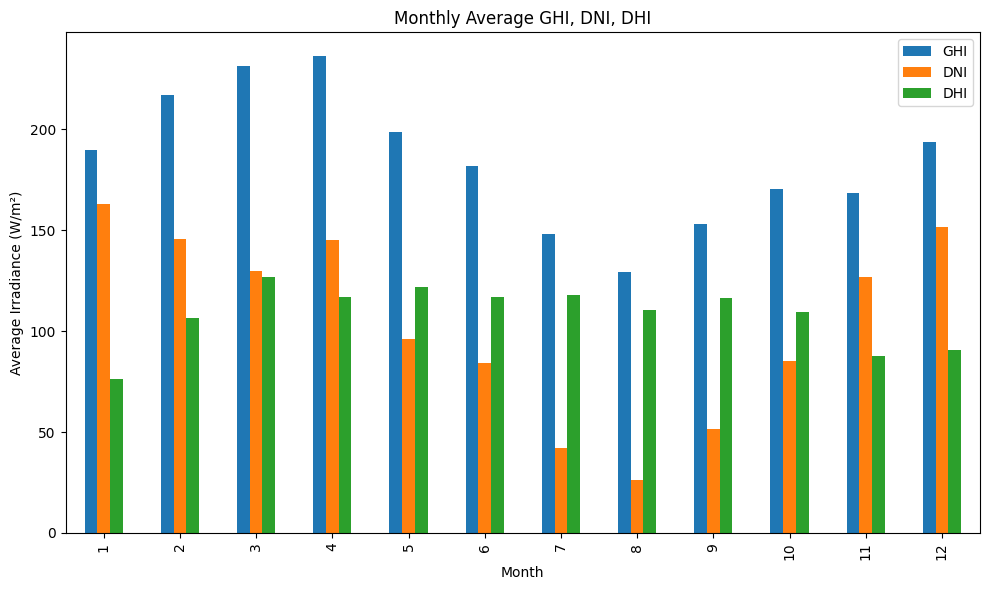

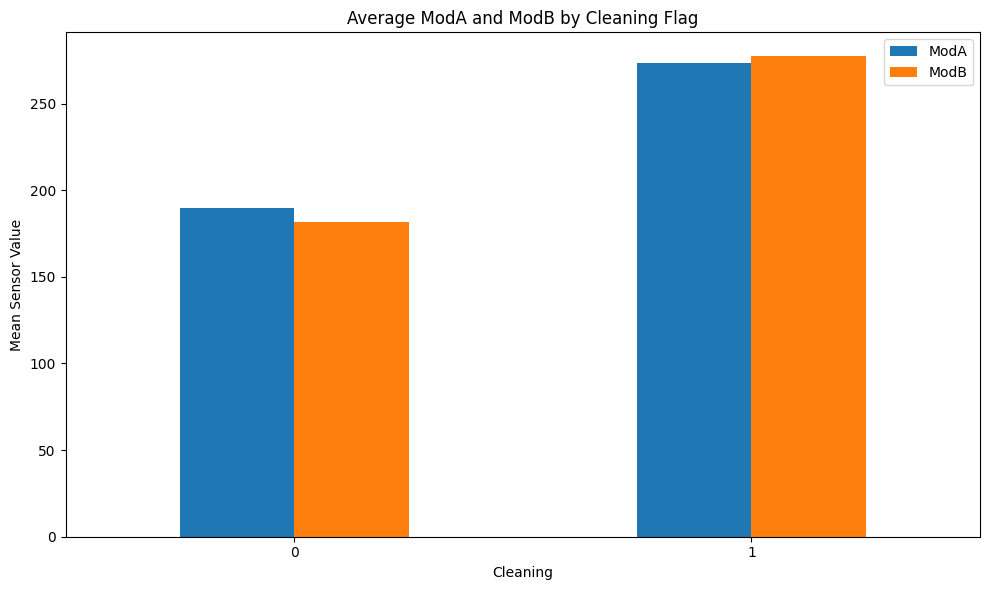

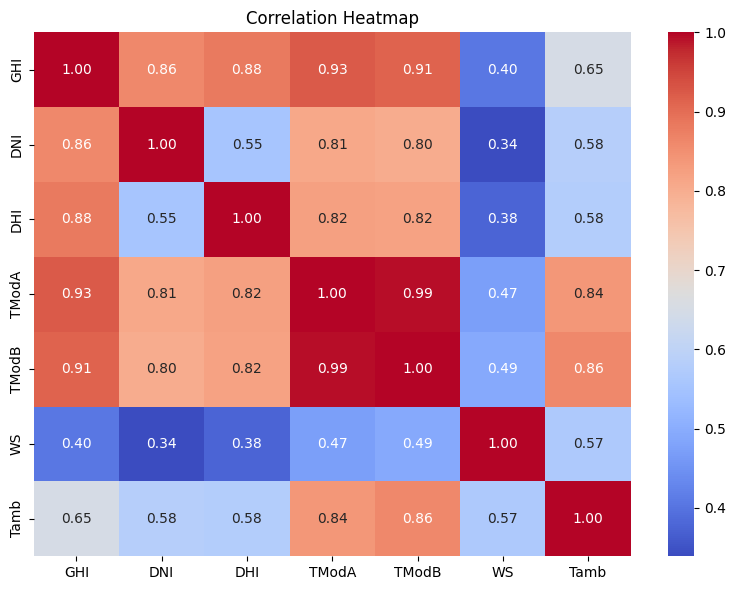

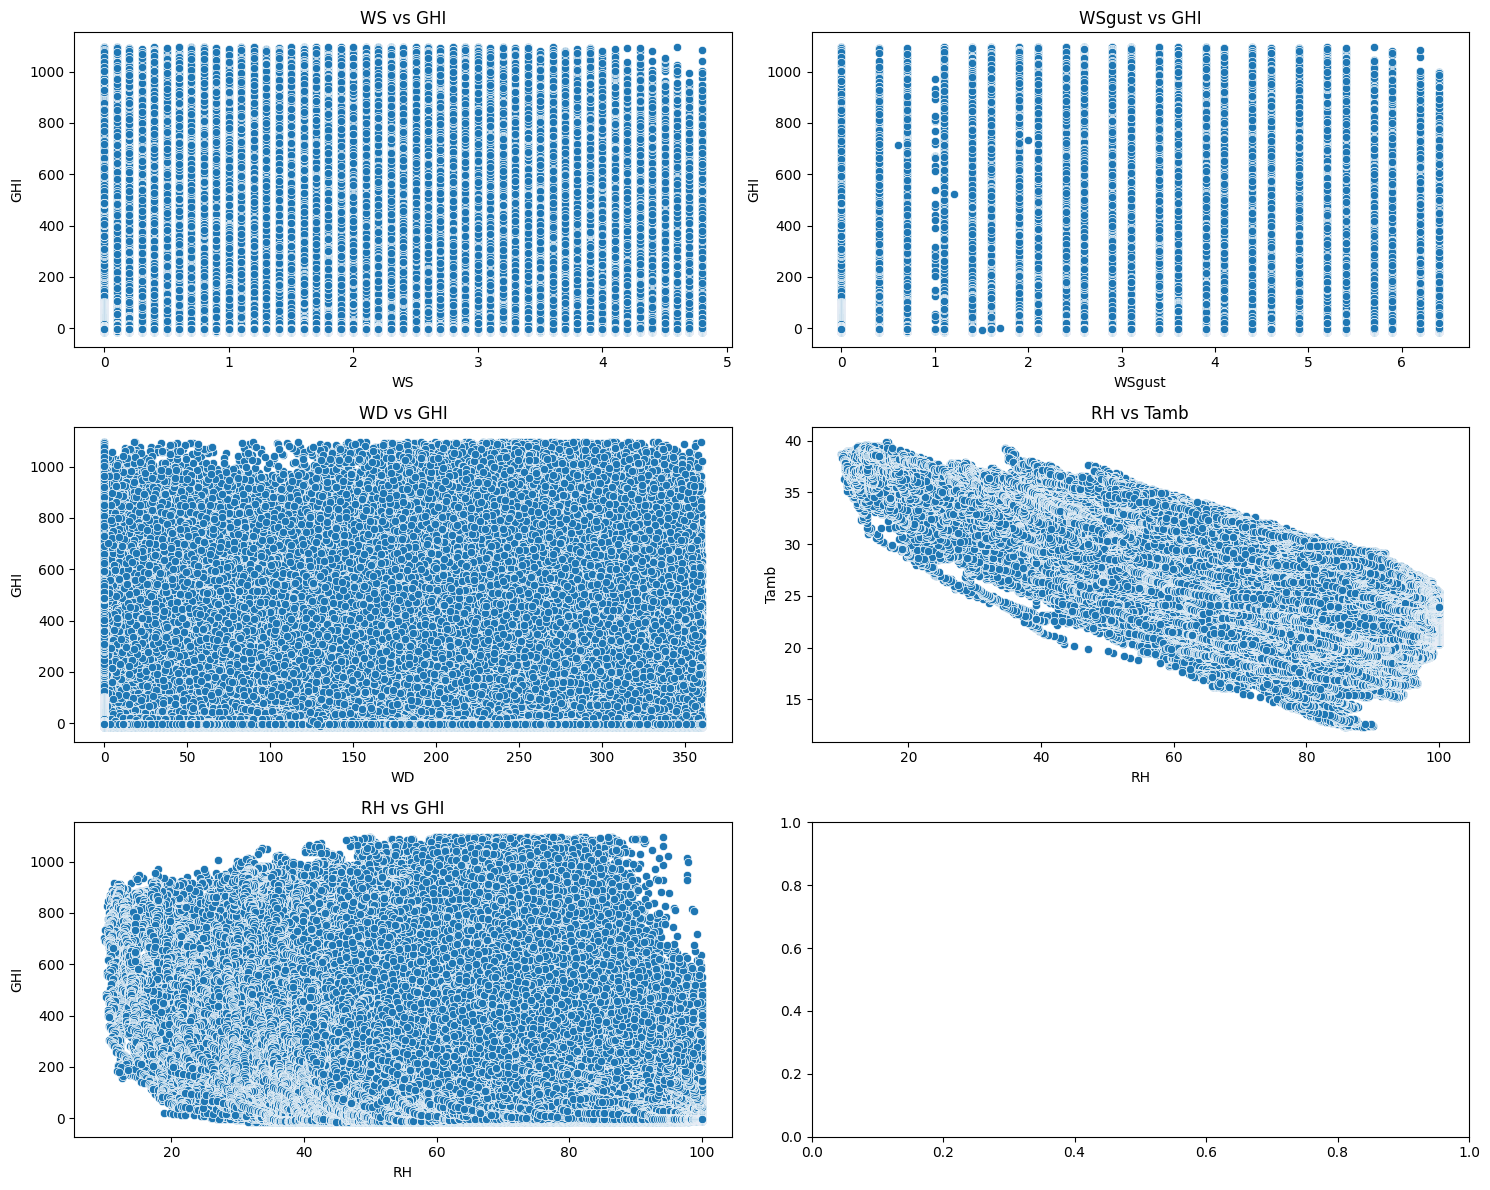

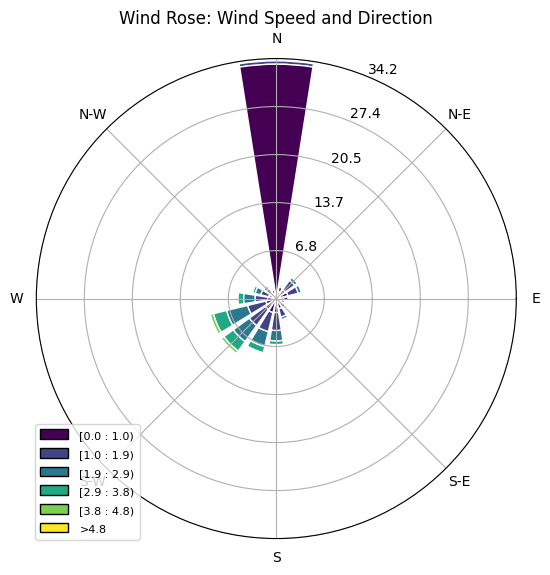

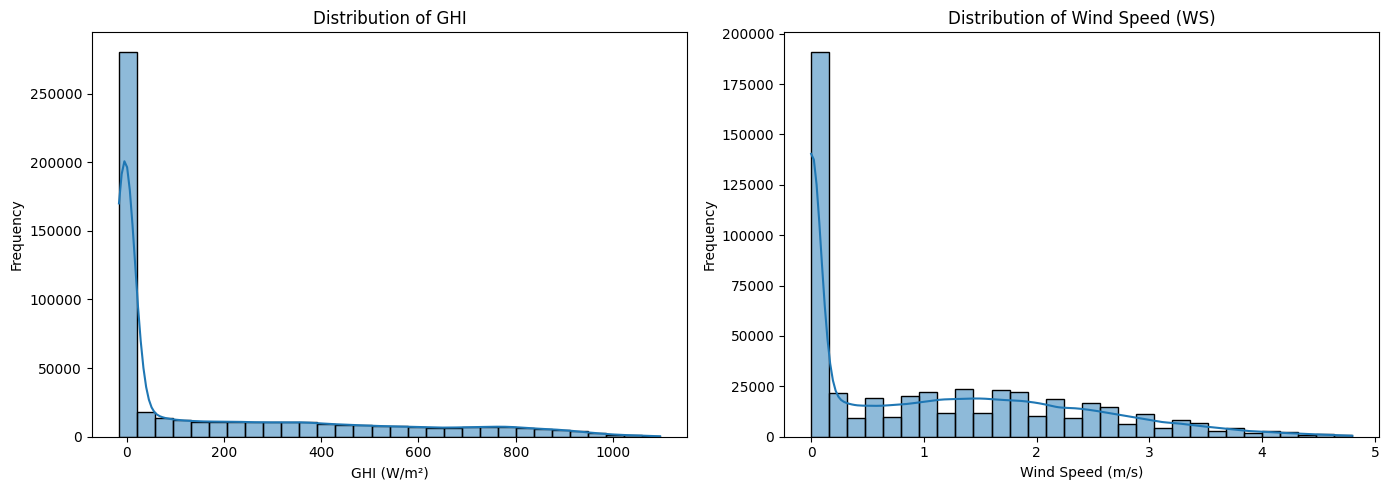

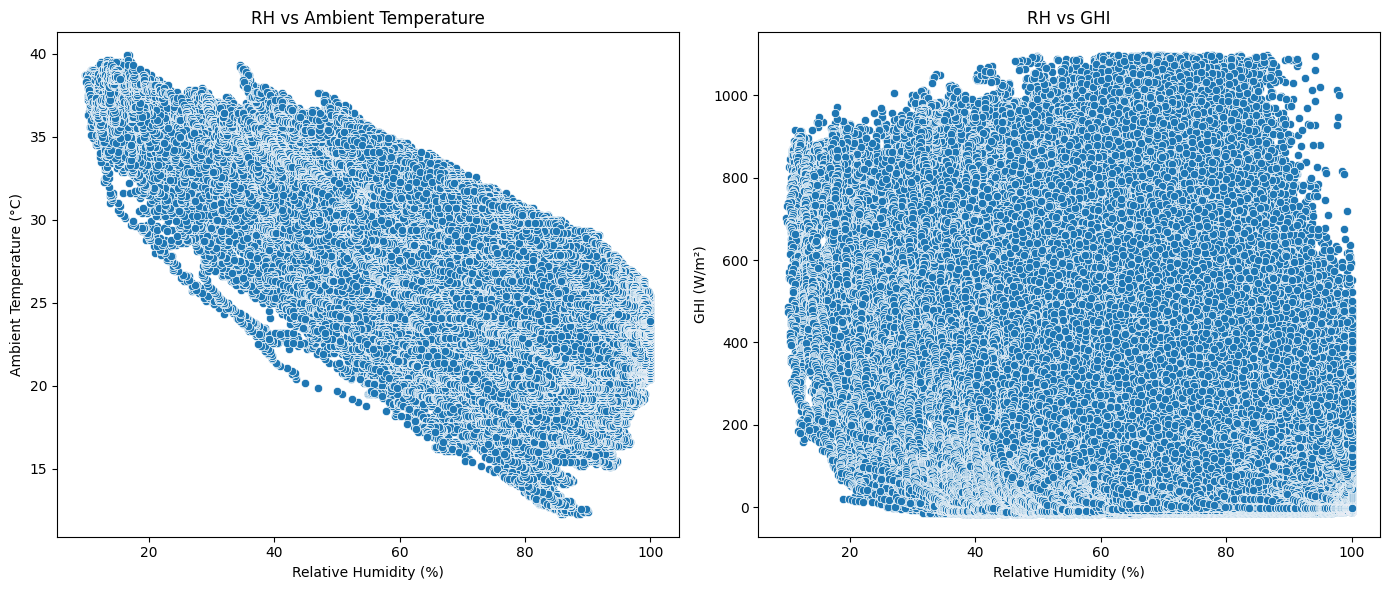

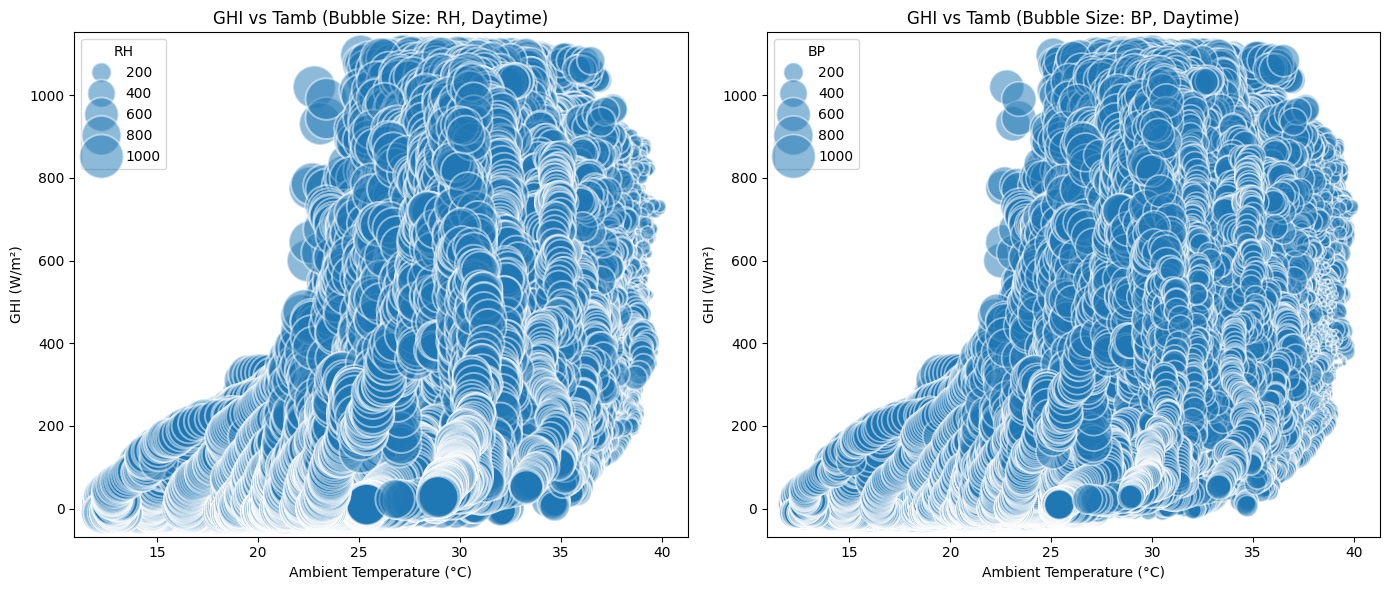

In [1]:
# Introduction / Purpose
# This notebook performs an exploratory data analysis (EDA) on the Sierraleone solar farm dataset to identify trends in solar radiation (GHI, DNI, DHI), temperature (Tamb, TModA, TModB), wind (WS, WD), and other meteorological variables. The analysis includes data cleaning to handle errors (e.g., negative irradiance values), outlier detection, and visualizations to uncover relationships and patterns.

# Data Loading
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
import os

# Create a directory for saving figures
os.makedirs('figures', exist_ok=True)

def load_data(filepath):
    """Loads CSV data into a pandas DataFrame with error handling."""
    try:
        df = pd.read_csv(filepath, parse_dates=['Timestamp'])
        print(f"Successfully loaded data from {filepath}")
        return df
    except FileNotFoundError:
        print(f"Error: File {filepath} not found. Please check the path.")
        raise
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load the dataset
df = load_data("../data/sierraleone-bumbuna.csv")

# Summary Stats & Nulls
# This section provides an overview of the dataset, including summary statistics and missing value analysis.
def plot_summary_statistics(df):
    """Prints summary statistics of the DataFrame."""
    print("Dataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())

def report_missing_values(df):
    """Prints a report of missing values in the DataFrame."""
    print("Missing Values per Column:")
    print(df.isna().sum())
    print("\nColumns with >5% missing values:")
    print(df.isna().mean()[df.isna().mean() > 0.05])

def plot_missing_values(df):
    """Plots a bar chart of missing values percentage."""
    missing = df.isna().mean() * 100
    plt.figure(figsize=(10, 6))
    missing[missing > 0].plot(kind='bar')
    plt.title("Percentage of Missing Values by Column")
    plt.ylabel("Missing Percentage (%)")
    plt.tight_layout()
    plt.savefig('figures/missing_values.png')

plot_summary_statistics(df)
report_missing_values(df)
plot_missing_values(df)

# Outlier Detection
# This section identifies outliers in key columns using z-scores.
def compute_z_scores(df, columns):
    """Computes z-scores for specified columns after filling NaNs with median."""
    df = df.copy()
    for col in columns:
        df[f'{col}_zscore'] = zscore(df[col].fillna(df[col].median()))
    return df

def plot_zscore_distribution(df, columns):
    """Plots distribution of z-scores for specified columns."""
    fig, axes = plt.subplots(len(columns), 1, figsize=(8, 4*len(columns)))
    if len(columns) == 1:
        axes = [axes]
    for i, col in enumerate(columns):
        z_col = f'{col}_zscore'
        if z_col in df:
            sns.histplot(df[z_col], bins=30, kde=True, ax=axes[i])
            axes[i].set_title(f'Z-score Distribution for {col}')
    plt.tight_layout()
    plt.savefig('figures/zscore_distribution.png')

def plot_boxplots(df, columns):
    """Plots boxplots for specified columns."""
    plt.figure(figsize=(12, 6))
    df[columns].boxplot()
    plt.title("Boxplots of Selected Columns")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('figures/boxplots.png')

columns_to_check = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
df_z = compute_z_scores(df, columns_to_check)
plot_zscore_distribution(df_z, columns_to_check)
plot_boxplots(df_z, columns_to_check)

# Data Cleaning
# This section cleans the data by handling negative irradiance values and removing outliers.
def handle_negative_irradiance(df, columns):
    """Replaces negative values in specified irradiance columns with NaN."""
    df = df.copy()
    for col in columns:
        df[col] = df[col].where(df[col] >= 0, np.nan)
    return df

def clean_outliers_and_missing(df, columns, z_threshold=3):
    """Cleans outliers based on z-scores and imputes missing values with median."""
    df = df.copy()
    print(f"Rows before cleaning: {len(df)}")
    for col in columns:
        z_col = f'{col}_zscore'
        if z_col in df:
            df = df[df[z_col].abs() <= z_threshold]
        df[col] = df[col].fillna(df[col].median())
        df.drop(columns=z_col, inplace=True, errors='ignore')
    print(f"Rows after cleaning: {len(df)}")
    return df

# Handle negative irradiance values (assumed to be errors)
irradiance_columns = ["GHI", "DNI", "DHI"]
df = handle_negative_irradiance(df, irradiance_columns)

# Apply cleaning
df_clean = clean_outliers_and_missing(df_z, columns_to_check)

# Export cleaned data
df_clean.to_csv("../data/sierraleone-bumbuna_clean.csv", index=False)

# EDA Plots
# This section generates visualizations to explore relationships and distributions in the data.
# Convert timestamp to datetime and set as index
df_clean["Timestamp"] = pd.to_datetime(df_clean["Timestamp"])
df_clean.set_index("Timestamp", inplace=True)

# Filter for daytime data (6 AM to 6 PM) for solar-related analysis
df_daytime = df_clean.between_time("06:00", "18:00")
print(f"Rows in full dataset: {len(df_clean)}")
print(f"Rows in daytime dataset (6 AM - 6 PM): {len(df_daytime)}")

# Time Series Plots
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
df_daytime["GHI"].plot(ax=axes[0], title="GHI over Time (Daytime)")
df_daytime["DNI"].plot(ax=axes[1], title="DNI over Time (Daytime)")
df_daytime["DHI"].plot(ax=axes[2], title="DHI over Time (Daytime)")
df_daytime["Tamb"].plot(ax=axes[3], title="Ambient Temperature over Time (Daytime)")
plt.tight_layout()
plt.savefig('figures/time_series_daytime.png')

# Monthly Averages
df_clean['Month'] = df_clean.index.month
monthly_avg = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI']].mean()
monthly_avg.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Average GHI, DNI, DHI')
plt.xlabel('Month')
plt.ylabel('Average Irradiance (W/m²)')
plt.tight_layout()
plt.savefig('figures/monthly_avg.png')

# Cleaning Impact
print("Distribution of Cleaning column:")
print(df_clean['Cleaning'].value_counts())
if len(df_clean['Cleaning'].unique()) > 1:
    fig, ax = plt.subplots(figsize=(10, 6))
    df_clean.groupby("Cleaning")[["ModA", "ModB"]].mean().plot(kind="bar", ax=ax)
    ax.set_title("Average ModA and ModB by Cleaning Flag")
    ax.set_ylabel("Mean Sensor Value")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('figures/cleaning_impact.png')
else:
    print("Cleaning column has no variation (all values are the same). Skipping cleaning impact plot.")

# Correlation Heatmap
corr_columns = ["GHI", "DNI", "DHI", "TModA", "TModB", "WS", "Tamb"]
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean[corr_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png')

# Scatter Plots
scatter_pairs = [
    ("WS", "GHI"), ("WSgust", "GHI"), ("WD", "GHI"),
    ("RH", "Tamb"), ("RH", "GHI")
]
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()
for i, (x, y) in enumerate(scatter_pairs):
    sns.scatterplot(data=df_clean, x=x, y=y, ax=axes[i])
    axes[i].set_title(f"{x} vs {y}")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
plt.tight_layout()
plt.savefig('figures/scatter_plots.png')

# Wind Rose Plot
fig = plt.figure(figsize=(8, 6))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df_clean["WD"], df_clean["WS"], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("Wind Rose: Wind Speed and Direction")
plt.tight_layout()
plt.savefig('figures/wind_rose.png')

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_clean["GHI"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of GHI")
axes[0].set_xlabel("GHI (W/m²)")
axes[0].set_ylabel("Frequency")
sns.histplot(df_clean["WS"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Wind Speed (WS)")
axes[1].set_xlabel("Wind Speed (m/s)")
axes[1].set_ylabel("Frequency")
plt.tight_layout()
plt.savefig('figures/histograms.png')

# Temperature Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=df_clean, x="RH", y="Tamb", ax=axes[0])
axes[0].set_title("RH vs Ambient Temperature")
axes[0].set_xlabel("Relative Humidity (%)")
axes[0].set_ylabel("Ambient Temperature (°C)")
sns.scatterplot(data=df_clean, x="RH", y="GHI", ax=axes[1])
axes[1].set_title("RH vs GHI")
axes[1].set_xlabel("Relative Humidity (%)")
axes[1].set_ylabel("GHI (W/m²)")
plt.tight_layout()
plt.savefig('figures/temperature_analysis.png')

# Bubble Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
rh_scaled = (df_daytime["RH"] - df_daytime["RH"].min()) / (df_daytime["RH"].max() - df_daytime["RH"].min()) * 990 + 10
bp_scaled = (df_daytime["BP"] - df_daytime["BP"].min()) / (df_daytime["BP"].max() - df_daytime["BP"].min()) * 990 + 10
sns.scatterplot(data=df_daytime, x="Tamb", y="GHI", size=rh_scaled, sizes=(10, 1000), alpha=0.5, ax=axes[0])
axes[0].set_title("GHI vs Tamb (Bubble Size: RH, Daytime)")
axes[0].set_xlabel("Ambient Temperature (°C)")
axes[0].set_ylabel("GHI (W/m²)")
sns.scatterplot(data=df_daytime, x="Tamb", y="GHI", size=bp_scaled, sizes=(10, 1000), alpha=0.5, ax=axes[1])
axes[1].set_title("GHI vs Tamb (Bubble Size: BP, Daytime)")
axes[1].set_xlabel("Ambient Temperature (°C)")
axes[1].set_ylabel("GHI (W/m²)")
plt.tight_layout()
plt.savefig('figures/bubble_chart_daytime.png')